## INSTALLING THE NECESSARY DEPENDENCIES:

In [1]:
##(install and restart runtime)
#!pip install --upgrade accelerate
#!pip install transformers[sentencepiece]

In [2]:
import torch
import numpy as np
import pandas as pd

!pip install transformers datasets huggingface_hub tensorboard==2.11
!sudo apt-get install git-lfs --yes
import os

from datasets import Dataset
from datasets import load_metric
from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import TrainingArguments, AutoModelForSequenceClassification, Trainer

torch.__version__


from huggingface_hub import HfFolder, notebook_login

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 100.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 83.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 77.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 19.9 MB/s eta 0:00:00
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.1
    Uninstalling tensorboard-data-server-0.7.1:
      Successfully uninstalled tensorboard-data-server-0.7.1
  Attempting uninstall: google-auth-oauthlib
    Found existing installation: google-auth-oauthlib 1.0.0
    Uninstalling google-auth-oauthlib-1.0.0:
      Successfully uninstalled google-auth-oauthlib-1.0.0
  Attemp

In [3]:
notebook_login()

In [4]:
repository_id = "Geee05/overlap3"

In [5]:
dataset = pd.read_csv('/content/All_transcript_train.csv')
tdataset= pd.read_csv('/content/All_transcript_test_new.csv')

In [6]:
(dataset[dataset['File']=='339_P']['Text'])

30    and I want to start up the virtual human to ch...
Name: Text, dtype: object

## DATA PRE-PROCESSING

In [7]:
dataset.rename(columns = {'Class':'labels'}, inplace = True)
tdataset.rename(columns = {'Group':'labels'}, inplace = True)

In [8]:
dataset.replace({'labels':{"HC":0,"DP":1}},inplace=True)
tdataset.replace({'labels':{"HC":0,"DP":1}},inplace=True)

In [9]:
dataset['labels'].value_counts()

0    126
1     37
Name: labels, dtype: int64

In [10]:
#resample data to deal with class imbalance
from sklearn.utils import resample
df_1=dataset[dataset['labels']==1]
df_2=dataset[dataset['labels']!=1]
df_upsampled=resample(df_1,random_state=42,n_samples=126,replace=True)
df=pd.concat([df_upsampled,df_2])
df.reset_index(inplace=True)

In [11]:
#creating Datasets
train = Dataset.from_pandas(df, preserve_index=False)
test = Dataset.from_pandas(tdataset, preserve_index=False)

print(train)
print(test)

Dataset({
    features: ['index', 'Unnamed: 0', 'File', 'Text', 'labels'],
    num_rows: 252
})
Dataset({
    features: ['Unnamed: 0.1', 'Unnamed: 0', 'File', 'Text', 'labels'],
    num_rows: 56
})


In [12]:
leng=[]
for i in range (0,len(train['Text'])):
  leng.append(len(train['Text'][i]))

print(min(leng))
print(max(leng))

1362
21064


### Function Definition:

In [13]:
#SEGMENT TEXTS
def segment_function(example):
  seg=example['Text']
  res=[]
  length=[]
  segmented_file=[]
  n=18000

  for iter in range (0,len(seg)):
    count=0
    for i in range (0,len(seg[iter])):
      j=i*9000
      if len(seg[iter])<18000:
          part=(seg[iter])
          res.append(part)
          count=1
          break
      elif j<=len(seg[iter]):
          segmented_file.append((example['File'][iter]))
          part=(seg[iter][j:j+n])
          res.append(part)
          #print(iter)

          count=count+1
      else:
        break
    length.append(count)

  return res,length#segmented_file

#TOKENIZE TEXTS
tokenizer = AutoTokenizer.from_pretrained('gooohjy/suicidal-electra')
def tokenize_function(example):
  return tokenizer(example["Text"], padding='max_length',max_length=512,truncation=True,add_special_tokens = True)

In [14]:
#LABELS CORR. TO SEGMENTS
label=[]
for i in range (0,len(train)):
  if (len(train['Text'][i])) <18000:
    label.append(train['labels'][i])
  else:
    x = ((len(train['Text'][i]))//9000) + 1
    for j in range (0,x):
      label.append(train['labels'][i])



label_t=[]
for i in range (0,len(test)):
  if (len(test['Text'][i])) <18000:
    label_t.append(test['labels'][i])
  else:
    x = ((len(test['Text'][i]))//9000) + 1
    for j in range (0,x):
      label_t.append(test['labels'][i])

#### Segmenting Train Data

In [16]:
ip_seg,leng=segment_function(train)
#ip_seg=segment_function(train)

In [18]:
print(len(leng))
print(sum(leng))
print(len(ip_seg))
#print(len(index))

252
266
266


In [20]:
#file_idx=np.array(index)
#np.unique(file_idx)

In [21]:
df_seg = pd.DataFrame(leng, columns=['segment_length'])
df_seg['segment_length'].value_counts()

1    245
3      7
Name: segment_length, dtype: int64

<Axes: >

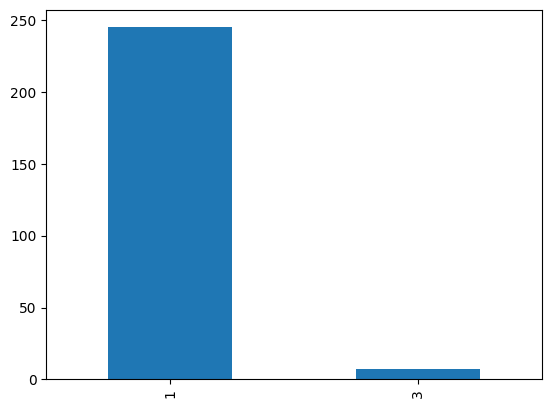

In [22]:
df_seg['segment_length'].value_counts().plot.bar()

In [19]:
#preparing dataframe for segmented texts & corresponding labels
train_data=pd.DataFrame(ip_seg,columns=['Text'])
train_data['labels']=label
train_data.head(2)

,Text,labels
0,okay hi I'm Ellie thanks for coming in today ...,1
1,and please are you okay yes I'm alright with ...,1


#### micsellaneous processing

In [21]:
lt=pd.read_csv("/content/logits_train_seq_modelling.csv")

FileNotFoundError: ignored

In [ ]:
lt=lt.append(x)
lt.sort_values(by=['Unnamed: 0'],inplace=True)
lt[28:29]

In [ ]:
lt[lt['subject']=='380_P']

In [ ]:
len(lt)

In [ ]:
lt.to_csv('logits_train_seq_modelling(updated).csv')

In [ ]:
x=one.append(two)
x=x.append(three)
x.drop(['logit'],axis=1,inplace=True)
x=x.append(four)
x=x.append(five)
x=x.append(six)
x=x.append(seven)
x

In [ ]:
seven=lt[163:166]
mean_1=seven['logit1'].mean()
mean_2=seven['logit2'].mean()
seven

In [ ]:
seven['logit1']=mean_1
seven['logit2']=mean_2
seven.drop([179,180],axis=0,inplace=True)
seven

In [ ]:
lt.drop([168,169,170,178,179,180],axis=0,inplace=True)


#### ------ end of miscellaneous processing

#### Tokenizing Train Data

In [23]:
trainset = Dataset.from_pandas(train_data, preserve_index=False)
trainset

Dataset({
    features: ['Text', 'labels'],
    num_rows: 266
})

In [24]:
tokenized_train_dataset = trainset.map(tokenize_function, batched=True)
tokenized_train_dataset

Map:   0%|          | 0/266 [00:00<?, ? examples/s]

Dataset({
    features: ['Text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 266
})

#### Segmenting Test Data

In [26]:
ip_seg_t,leng=segment_function(test)

test_data=pd.DataFrame(ip_seg_t,columns=['Text'])
test_data['labels']=label_t
test_data.head(2)

,Text,labels
0,okay there she is coming to go ahead and Shrin...,0
1,this is super need I like this me either at a...,1


#### Tokenizing Test Data

In [27]:
testset = Dataset.from_pandas(test_data, preserve_index=False)
testset

Dataset({
    features: ['Text', 'labels'],
    num_rows: 56
})

In [28]:
tokenized_test_dataset = testset.map(tokenize_function, batched=True)
tokenized_test_dataset

Map:   0%|          | 0/56 [00:00<?, ? examples/s]

Dataset({
    features: ['Text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 56
})

### Review

In [29]:
#tokenizer.model_max_length =512

In [30]:
print(len(label))
print(len(label_t))


266
56


In [31]:
print(len(ip_seg))
print(len(ip_seg_t))


266
56


In [32]:
type(tokenized_train_dataset)

datasets.arrow_dataset.Dataset

## TRAINING

In [33]:
# Set dataset format using set_format() function to specify the dataset format, making it compatible with PyTorch
tokenized_train_dataset.set_format("torch", columns=['input_ids','attention_mask','labels'])
tokenized_test_dataset.set_format("torch", columns=['input_ids','attention_mask','labels'])

In [34]:
os.environ["WANDB_DISABLED"] = "true"

In [35]:
from sklearn.metrics import classification_report

training_args = TrainingArguments(evaluation_strategy="epoch",num_train_epochs=35,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    weight_decay=0.01,
    warmup_steps=500,
    output_dir=repository_id,
    logging_dir=f"{repository_id}/logs",
    logging_strategy="steps",
    logging_steps=10,
    save_strategy="epoch",
    load_best_model_at_end=True,
    save_total_limit=2,
    metric_for_best_model="f1",
    greater_is_better=True,
    report_to="tensorboard",
    push_to_hub=True,
    hub_strategy="every_save",
    hub_model_id=repository_id,
    hub_token=HfFolder.get_token())   # default arguments for fine-tuning
model = AutoModelForSequenceClassification.from_pretrained('gooohjy/suicidal-electra', num_labels=2) #,ignore_mismatched_sizes=True
def compute_metrics(eval_pred):
    load_accuracy = load_metric("accuracy")
    load_f1 = load_metric("f1")

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    #probabilities = softmax(logits, axis=-1)
    accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
    f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]
    return {"accuracy": accuracy, "f1": f1}
    print((classification_report(labels,predictions)))

trainer = Trainer(   # specifying trainer class
    model,
    training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    #data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


Cloning https://huggingface.co/Geee05/overlap3 into local empty directory.


Download file pytorch_model.bin:   0%|          | 7.40k/418M [00:00<?, ?B/s]

Download file logs/events.out.tfevents.1689081645.7d3dc4338c11.1189.0:  47%|####6     | 16.5k/35.2k [00:00<?, …

Download file logs/events.out.tfevents.1689322377.c8c2ee6f7a93.6264.1: 100%|##########| 17.6k/17.6k [00:00<?, …

Download file logs/events.out.tfevents.1689410656.040d19d84760.19403.0:   4%|4         | 1.40k/34.9k [00:00<?,…

Download file logs/events.out.tfevents.1689325120.c8c2ee6f7a93.6264.2:  53%|#####2    | 18.4k/34.9k [00:00<?, …

Download file logs/events.out.tfevents.1689134850.90d5f30f9684.819.1: 100%|##########| 17.2k/17.2k [00:00<?, ?…

Download file logs/events.out.tfevents.1689316707.c8c2ee6f7a93.6264.0:  47%|####6     | 16.5k/35.2k [00:00<?, …

Download file logs/events.out.tfevents.1689126618.90d5f30f9684.819.0:  47%|####6     | 16.5k/35.2k [00:00<?, ?…

Clean file logs/events.out.tfevents.1689322377.c8c2ee6f7a93.6264.1:   6%|5         | 1.00k/17.6k [00:00<?, ?B/…

Clean file logs/events.out.tfevents.1689134850.90d5f30f9684.819.1:   6%|5         | 1.00k/17.2k [00:00<?, ?B/s…

Clean file logs/events.out.tfevents.1689081645.7d3dc4338c11.1189.0:   3%|2         | 1.00k/35.2k [00:00<?, ?B/…

Clean file logs/events.out.tfevents.1689325120.c8c2ee6f7a93.6264.2:   3%|2         | 1.00k/34.9k [00:00<?, ?B/…

Clean file logs/events.out.tfevents.1689410656.040d19d84760.19403.0:   3%|2         | 1.00k/34.9k [00:00<?, ?B…

Clean file logs/events.out.tfevents.1689316707.c8c2ee6f7a93.6264.0:   3%|2         | 1.00k/35.2k [00:00<?, ?B/…

Clean file logs/events.out.tfevents.1689126618.90d5f30f9684.819.0:   3%|2         | 1.00k/35.2k [00:00<?, ?B/s…

Download file training_args.bin: 100%|##########| 3.87k/3.87k [00:00<?, ?B/s]

Clean file training_args.bin:  26%|##5       | 1.00k/3.87k [00:00<?, ?B/s]

Clean file pytorch_model.bin:   0%|          | 1.00k/418M [00:00<?, ?B/s]

In [36]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a ElectraTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,2.611000,0.948548,0.767857,0.480000
2,1.022000,1.094700,0.642857,0.500000
3,0.588900,1.132009,0.553571,0.468085
4,0.368400,0.865704,0.642857,0.473684
5,0.443600,1.598298,0.517857,0.509091
6,0.151000,1.305757,0.589286,0.439024
7,0.058000,1.841437,0.571429,0.478261
8,0.001400,1.767039,0.732143,0.516129
9,0.041700,1.701982,0.803571,0.521739
10,0.000300,2.132227,0.714286,0.500000


<ipython-input-35-a51742d4a3cf>:25: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  load_accuracy = load_metric("accuracy")


TrainOutput(global_step=1190, training_loss=0.1810435543974525, metrics={'train_runtime': 1882.7422, 'train_samples_per_second': 4.945, 'train_steps_per_second': 0.632, 'total_flos': 2449563925401600.0, 'train_loss': 0.1810435543974525, 'epoch': 35.0})

In [37]:
# Save our tokenizer and create a model card
tokenizer.save_pretrained(repository_id)
trainer.create_model_card()
# Push the results to the hub
trainer.push_to_hub()

Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 1.00/418M [00:00<?, ?B/s]

Upload file logs/events.out.tfevents.1690022703.2250437ebebe.12831.0:   0%|          | 1.00/35.2k [00:00<?, ?B…

To https://huggingface.co/Geee05/overlap3
   eaff46b..5facc4d  main -> main

   eaff46b..5facc4d  main -> main



'https://huggingface.co/Geee05/overlap3/commit/5facc4d1420c7a536c394e063d26a9a7faf54ca2'

In [38]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("Geee05/overlap3")
model_electra = AutoModelForSequenceClassification.from_pretrained("Geee05/overlap3")

In [ ]:
last_hidden_states=[]
attentions=[]
labels=[]
for i in range (0,len(tokenized_test_dataset['Text'])):

  inputs = tokenizer(tokenized_test_dataset['Text'][i],padding='max_length',max_length=512,truncation=True,add_special_tokens = True, return_tensors="pt")
  with torch.no_grad():
    outputs = model_electra(**inputs,output_hidden_states=True,output_attentions=True)
    #print(outputs.hidden_states)
    #logits_prev = outputs.attentions
    #print(outputs.attentions)
    attentions.append(outputs.attentions)
    #print(logits)
    #last_hidden_states.append(logits_prev)
  #print(outputs.keys())
    #labels_i = logits_l.argmax().item()
  #labels.append(labels_i)


In [ ]:
np.array(attentions[0][11])#.shape

In [ ]:
print((np.array(last_hidden_states[14]).shape))

In [ ]:
np.array(last_hidden_states[0][10])

In [ ]:
predict_t=trainer.predict(tokenized_test_dataset)

In [ ]:
speakertest=[]
for i in range (0,len(test)):
  if (len(test['Text'][i])) <18000:
    speakertest.append(test['File'][i])
  else:
    x = ((len(test['Text'][i]))//9000) + 1
    for j in range (0,x):
      speakertest.append(test['File'][i])

In [ ]:
len(speakertest)

In [ ]:
len(predict_t[0])

In [ ]:
true_labels_te=[]
for i in range (0,len(tokenized_test_dataset['labels'])):
  true_labels_te.append(tokenized_test_dataset['labels'][i])


In [ ]:
len(true_labels_te)

In [ ]:
dfte=pd.DataFrame(predict_t[0], columns=["logit1","logit2"])
dfte['speaker']=speakertest
dfte['class']=true_labels_te
dfte['class']=dfte['class'].astype(int)
#dft['pred_labels']=predict[1]
dfte

In [ ]:
dfte.to_csv('logits_test_seq_modelling.csv')

In [74]:
speakert=[]
for i in range (0,len(train)):
  if (len(train['Text'][i])) <18000:
    speakert.append(train['File'][i])
  else:
    x = ((len(train['Text'][i]))//9000) + 1
    for j in range (0,x):
      speakert.append(train['File'][i])

In [75]:
len(speakert)

266

In [76]:
true_labels_t=[]
for i in range (0,len(tokenized_train_dataset['labels'])):
  true_labels_t.append(tokenized_train_dataset['labels'][i])


In [ ]:
dft=pd.DataFrame(predict[0], columns=["logit1","logit2"])
dft['subject']=speakert
dft['class']=true_labels_t
dft['class']=dft['class'].astype(int)
#dft['pred_labels']=predict[1]
dft

In [ ]:
dft['subject'].value_counts()

In [ ]:
dft.to_csv('logits_train_seq_modelling.csv')

In [ ]:
PATH = trainer.state.best_model_checkpoint

## VALIDATION

In [39]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("Geee05/overlap3")
model_electra = AutoModelForSequenceClassification.from_pretrained("Geee05/overlap3")

In [40]:
vdataset= pd.read_csv('/content/All_transcript_val_new.csv')

In [41]:
vdataset.head(2)

,Unnamed: 0.1,Unnamed: 0,File,Text,Group
0,0,0,600_AUDIO,okay there she is coming to go ahead and Shrin...,HC
1,1,1,602_AUDIO,this is super need I like this me either at a...,DP


In [42]:
vdataset.rename(columns = {'Group':'labels'}, inplace = True)
vdataset.replace({'labels':{"HC":0,"DP":1}},inplace=True)
vdataset['labels'].value_counts()

0    39
1    17
Name: labels, dtype: int64

In [43]:
val = Dataset.from_pandas(vdataset, preserve_index=False)
print(val)

Dataset({
    features: ['Unnamed: 0.1', 'Unnamed: 0', 'File', 'Text', 'labels'],
    num_rows: 56
})


In [44]:
#LABELS CORR. TO SEGMENTS

label_v=[]
for i in range (0,len(val)):
  if (len(val['Text'][i])) <18000:
    label_v.append(val['labels'][i])
  else:
    x = ((len(val['Text'][i]))//9000) + 1
    for j in range (0,x):
      label_v.append(val['labels'][i])

In [45]:
ip_seg_v,seg_len=segment_function(val)

In [46]:
print(len(label_v))
print(len(ip_seg_v))

56
56


In [48]:
ip_seg_v,leng=segment_function(val)

val_data=pd.DataFrame(ip_seg_v,columns=['Text'])
val_data['labels']=label_v
val_data.head(2)

,Text,labels
0,okay there she is coming to go ahead and Shrin...,0
1,this is super need I like this me either at a...,1


In [49]:
valset = Dataset.from_pandas(val_data, preserve_index=False)
valset

Dataset({
    features: ['Text', 'labels'],
    num_rows: 56
})

In [50]:
tokenized_val_dataset = valset.map(tokenize_function, batched=True)
tokenized_val_dataset

Map:   0%|          | 0/56 [00:00<?, ? examples/s]

Dataset({
    features: ['Text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 56
})

In [51]:
tokenized_val_dataset.set_format("torch", columns=['input_ids','attention_mask','labels'])

In [52]:
tokenized_val_dataset

Dataset({
    features: ['Text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 56
})

In [53]:
tokenized_val_dataset['input_ids'].shape

torch.Size([56, 512])

In [54]:
logits=[]
labels=[]
for i in range (0,len(tokenized_val_dataset['Text'])):

  inputs = tokenizer(tokenized_val_dataset['Text'][i],padding='max_length',max_length=512,truncation=True,add_special_tokens = True, return_tensors="pt")
  with torch.no_grad():
    outputs = model_electra(**inputs)
    logits_l = model_electra(**inputs).logits
    #print(logits)
    logits.append(logits_l)
    labels_i = logits_l.argmax().item()
  labels.append(labels_i)

  #print(labels)

    #print(outputs)
  #print(np.array(inputs['input_ids']).shape)
  #print(np.array(inputs['token_type_ids']).shape)
  #print(np.array(inputs['attention_mask']).shape)
  #print(**inputs.shape)

  #last_hidden_states = outputs.last_hidden_state
  #result.append(outputs)

In [55]:
len(labels)

56

In [56]:
len(logits)

56

In [57]:
true_labels=[]
for i in range (0,len(tokenized_val_dataset['labels'])):
  true_labels.append(tokenized_val_dataset['labels'][i])


In [58]:
len(true_labels)

56

In [59]:
from sklearn.metrics import classification_report

print(classification_report(true_labels,labels))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88        39
           1       1.00      0.35      0.52        17

    accuracy                           0.80        56
   macro avg       0.89      0.68      0.70        56
weighted avg       0.85      0.80      0.77        56



## INFERENCE

In [60]:
logit1=[]
for i in range (0,len(logits)):
  logith=logits[i][0][0]
  logit1.append(logith)

logit2=[]
for i in range (0,len(logits)):
  logitd=logits[i][0][1]
  logit2.append(logitd)

###### A probability of 0.5 corresponds to a logit of 0 </br>
###### Negative logit values indicate probabilities smaller than 0.5 </br>
###### Positive logits indicate probabilities greater than 0.5 </br>

In [61]:
new_df=pd.DataFrame(logit1, columns=["logit1"])
new_df['logit2']=logit2

new_df['logit1']=new_df['logit1'].astype(float)
new_df['logit2']=new_df['logit2'].astype(float)

new_df['prob1']=1/(1+(np.exp(-new_df['logit1'])))
new_df['prob2']=1/(1+(np.exp(-new_df['logit2'])))

new_df['pred_label']=labels

new_df

,logit1,logit2,prob1,prob2,pred_label
0,3.496282,-3.511748,0.970582,0.028980,0
1,4.616393,-4.662120,0.990208,0.009358,0
2,4.652236,-4.744146,0.990550,0.008627,0
3,4.807645,-4.892371,0.991899,0.007448,0
4,5.005806,-5.116095,0.993346,0.005964,0
5,3.856522,-3.895157,0.979296,0.019935,0
6,5.033869,-5.138346,0.993529,0.005833,0
7,4.895020,-4.979069,0.992572,0.006833,0
8,4.628479,-4.699993,0.990325,0.009013,0
9,4.053736,-4.099168,0.982939,0.016316,0


In [62]:
speaker=[]
for i in range (0,len(val)):
  if (len(val['Text'][i])) <18000:
    speaker.append(val['File'][i])
  else:
    x = ((len(val['Text'][i]))//9000) + 1
    for j in range (0,x):
      speaker.append(val['File'][i])

In [63]:
len(speaker)

56

In [64]:
df=pd.DataFrame(speaker, columns=["speaker"])
df['logit1']=logit1
df['logit1']=df['logit1'].astype(float)
df['logit2']=logit2
df['logit2']=df['logit2'].astype(float)
df['Class']=true_labels
df['Class']=df['Class'].astype(int)
df.head(3)

,speaker,logit1,logit2,Class
0,600_AUDIO,3.496282,-3.511748,0
1,602_AUDIO,4.616393,-4.662120,1
2,604_AUDIO,4.652236,-4.744146,1


In [ ]:
df.to_csv('logits_seq_modelling.csv')

#### miscellaneous:

In [65]:
from transformers import ElectraTokenizer, ElectraModel
import torch

tokenizer = ElectraTokenizer.from_pretrained('google/electra-small-discriminator')
model = ElectraModel.from_pretrained('google/electra-small-discriminator', return_dict=True)

inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
outputs = model(**inputs)

last_hidden_states = outputs.last_hidden_state

In [66]:
last_hidden_states.shape

torch.Size([1, 8, 256])

In [67]:
inputs

{'input_ids': tensor([[  101,  7592,  1010,  2026,  3899,  2003, 10140,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}

In [68]:
tokenizer_e = ElectraTokenizer.from_pretrained('google/electra-small-discriminator')
model_e = ElectraModel.from_pretrained('google/electra-small-discriminator', return_dict=True)

#last_hidden_states=[]
hidden_states=[]
labels=[]
for i in range (0,len(tokenized_test_dataset['Text'])):

  inputs = tokenizer_e(tokenized_test_dataset['Text'][i],padding='max_length',max_length=512,truncation=True,add_special_tokens = True, return_tensors="pt")
  with torch.no_grad():
    outputs = model_e(**inputs)
    logits_prev = outputs.hidden_states
    hidden_states.append(logits_prev)

In [69]:
np.array(last_hidden_states[0])

RuntimeError: ignored

In [ ]:
!pip install gradio

In [ ]:
import pickle
import gradio as gr

In [ ]:
with open("model_electra.pkl", "wb") as f:
  pickle.dump(model_electra, f)

In [ ]:
with open("model_electra.pkl", "rb") as f:
	model_electra = pickle.load(f)

In [ ]:
model_electra